In [14]:
# Authors: Carolina Fernandez <cxf418@miami.edu>
#          Nick Tolley <nicholas_tolley@brown.edu>
#          Ryan Thorpe <ryan_thorpe@brown.edu>
#          Mainak Jas <mjas@mgh.harvard.edu>

from hnn_core.optimization import Optimizer
from urllib.request import urlretrieve
import os.path as op

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hnn_core
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole,
                      read_dipole)
from hnn_core.dipole import _rmse, average_dipoles
from hnn_core.viz import plot_dipole

import pickle

hnn_core_root = op.join(op.dirname(hnn_core.__file__))

# The number of cores may need modifying depending on your current machine.
n_procs = 1

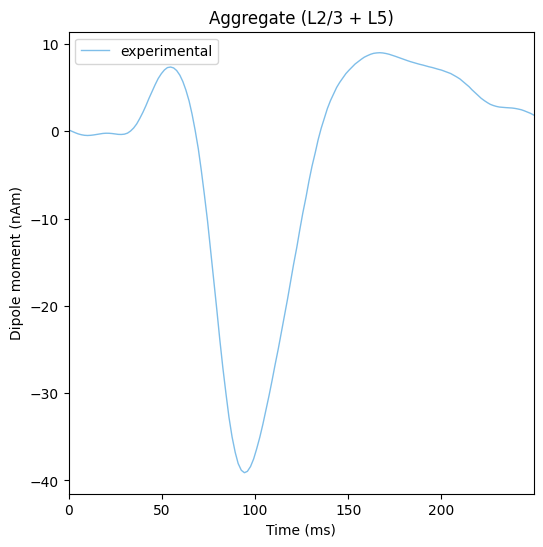

In [2]:
dipole_experimental = read_dipole('../data/L_Contra.txt')

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:blue')
ax.legend(['experimental'])

In [3]:
def set_params(net, params):

    # Add proximal drives
    weights_ampa_p1 = {"L2_basket": 0.08831 * (10 ** params['evprox1_ampa_L2_basket']),
                       "L2_pyramidal": 0.01525 * (10 ** params['evprox1_ampa_L2_pyramidal']),
                       "L5_basket": 0.19934 * (10 ** params['evprox1_ampa_L5_basket']),
                       "L5_pyramidal": 0.00865 * (10 ** params['evprox1_ampa_L5_pyramidal']),}
    synaptic_delays_p = {"L2_basket": 0.1, "L2_pyramidal": 0.1,
                            "L5_basket": 1.0,"L5_pyramidal": 1.0,}

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=params['evprox1_mu'],
                         sigma=params['evprox1_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         synaptic_delays=synaptic_delays_p)


    # Add distal drive
    weights_ampa_d1 = {"L2_basket": 0.006562 * (10 ** params['evdist1_ampa_L2_basket']),
                       "L2_pyramidal": 7e-6 * (10 ** params['evdist1_ampa_L2_pyramidal']),
                       "L5_pyramidal": 0.142300 * (10 ** params['evdist1_ampa_L5_pyramidal']),}
    weights_nmda_d1 = {"L2_basket": 0.019482 * (10 ** params['evdist1_nmda_L2_basket']),
                        "L2_pyramidal": 0.004317 * (10 ** params['evdist1_nmda_L2_pyramidal']),
                        "L5_pyramidal": 0.080074 * (10 ** params['evdist1_nmda_L5_pyramidal']),}
    synaptic_delays_d1 = {"L2_basket": 0.1, "L2_pyramidal": 0.1, "L5_pyramidal": 0.1}

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=params['evdist1_mu'],
                         sigma=params['evdist1_sigma'],
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket': 0.000003 * (10 ** params['evprox2_ampa_L2_basket']),
                       'L2_pyramidal': 1.438840 * (10 ** params['evprox2_ampa_L2_pyramidal']),
                       'L5_basket': 0.008958 * (10 ** params['evprox2_ampa_L5_basket']),
                       'L5_pyramidal': 0.684013 * (10 ** params['evprox2_ampa_L5_pyramidal'])}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         synaptic_delays=synaptic_delays_p)


def _rmse_evoked(
    initial_net,
    initial_params,
    set_params,
    predicted_params,
    update_params,
    obj_values,
    tstop,
    obj_fun_kwargs,
):
    """The objective function for evoked responses.

    Parameters
    ----------
    initial_net : instance of Network
        The network object.
    initial_params : dict
        Keys are parameter names, values are initial parameters.
    set_params : func
        User-defined function that sets network drives and parameters.
    predicted_params : list
        Parameters selected by the optimizer.
    update_params : func
        Function to update params.
    tstop : float
        The simulated dipole's duration.
    target : instance of Dipole
        A dipole object with experimental data.
    n_trials : int
        Number of trials to simulate and average.

    Returns
    -------
    obj : float
        Normalized RMSE between recorded and simulated dipole.
    """

    params = update_params(initial_params, predicted_params)

    # simulate dpl with predicted params
    new_net = initial_net.copy()
    set_params(new_net, params)

    dpls = simulate_dipole(new_net, tstop=tstop, n_trials=obj_fun_kwargs["n_trials"], dt=obj_fun_kwargs['dt'])

    # smooth & scale
    if "scale_factor" in obj_fun_kwargs:
        [dpl.scale(obj_fun_kwargs["scale_factor"]) for dpl in dpls]
    if "smooth_window_len" in obj_fun_kwargs:
        [dpl.smooth(obj_fun_kwargs["smooth_window_len"]) for dpl in dpls]

    dpl = average_dipoles(dpls)
    obj = _rmse(dpl, obj_fun_kwargs["target"], tstop=tstop)
    obj_values.append(obj)

    print(f'RMSE: {obj:.2f}')

    return obj

In [4]:
constraints = dict({'evprox1_ampa_L5_pyramidal':(-4, 4),
                    'evprox1_ampa_L2_pyramidal':(-4, 4),
                    'evprox1_ampa_L5_basket':(-4, 4),
                    'evprox1_ampa_L2_basket':(-4, 4),
                    'evprox1_mu': (30., 60.),
                    'evprox1_sigma': (1., 50.),
                    
                    'evdist1_ampa_L5_pyramidal': (-4, 4),
                    'evdist1_nmda_L5_pyramidal': (-4, 4),
                    'evdist1_ampa_L2_pyramidal': (-4, 4),
                    'evdist1_nmda_L2_pyramidal': (-4, 4),
                    'evdist1_ampa_L2_basket': (-4, 4),
                    'evdist1_nmda_L2_basket': (-4, 4),
                    'evdist1_mu': (70., 100.),
                    'evdist1_sigma': (1., 50.),

                    'evprox2_ampa_L5_pyramidal': (-4, 4),
                    'evprox2_ampa_L2_pyramidal': (-4, 4),
                    'evprox2_ampa_L5_basket':(-4, 4),
                    'evprox2_ampa_L2_basket':(-4, 4),
                    'evprox2_mu': (120., 150.),
                    'evprox2_sigma': (1., 50.),
                    })

initial_params = dict({'evprox1_ampa_L5_pyramidal': 0,
                       'evprox1_ampa_L2_pyramidal': 0,
                       'evprox1_ampa_L5_basket': 0,
                       'evprox1_ampa_L2_basket': 0,
                       'evprox1_mu': 60.,
                       'evprox1_sigma': 1.,

                       'evdist1_ampa_L5_pyramidal': 0,
                       'evdist1_nmda_L5_pyramidal': 0,
                       'evdist1_ampa_L2_pyramidal': 0,
                       'evdist1_nmda_L2_pyramidal': 0,
                       'evdist1_ampa_L2_basket': 0,
                       'evdist1_nmda_L2_basket': 0,
                       'evdist1_mu': 100.,
                       'evdist1_sigma': 1.,

                       'evprox2_ampa_L5_pyramidal': 0,
                       'evprox2_ampa_L2_pyramidal': 0,
                       'evprox2_ampa_L5_basket': 0,
                       'evprox2_ampa_L2_basket': 0,
                       'evprox2_mu': 150.,
                       'evprox2_sigma': 1.,
                       
                       })

In [5]:
n_trials = 1
scaling_factor = 1000
# scaling_factor = 2000 # use for dt=0.5
window_length = 40
tstop = 250
dt = 0.025

net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints,
                  set_params=set_params, initial_params=initial_params, max_iter=100, obj_fun=_rmse_evoked)
                  
optim.fit(target=dipole_experimental, n_trials=n_trials, scale_factor=scaling_factor,
            smooth_window_len=window_length, dt=dt)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
RMSE: 10.02
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Tri

In [6]:
dipoles_optimized = simulate_dipole(
        optim.net_, tstop=tstop, n_trials=n_trials, dt=dt)

# Smooth and scale
for dipole in dipoles_optimized:
    dipole.smooth(window_length).scale(scaling_factor)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...


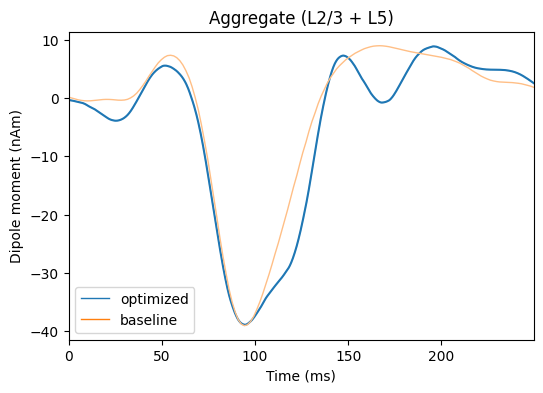

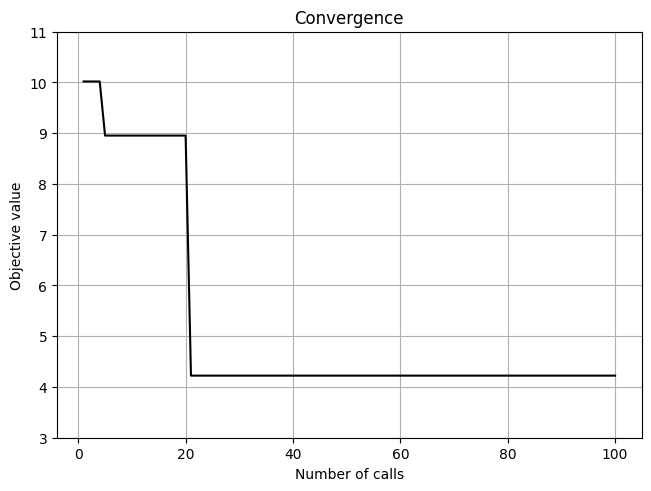

In [13]:
fig, ax = plt.subplots(sharex=True, figsize=(6,4))

plot_dipole(dipoles_optimized.copy(), ax=ax, layer='agg',
            show=False, color='tab:blue', average=True)
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:orange')

# Legend
legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.0),
                  Line2D([0], [0], color='tab:orange', lw=1.0),
                  Line2D([0], [0], color='tab:green', lw=1.0)]
ax.legend(legend_handles, ['optimized', 'baseline'])

# Convergence plot
optim.plot_convergence()
plt.ylim(3, 11)
plt.show()

In [11]:
optim.net_.write_configuration('../data/opt_baseline_config.json')

In [8]:
print(list(dir(optim)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_assemble_constraints', '_initial_net', '_run_opt', '_set_params', 'constraints', 'fit', 'initial_params', 'max_iter', 'net_', 'obj_', 'obj_fun', 'obj_fun_name', 'opt_params_', 'plot_convergence', 'solver', 'tstop']


In [16]:
with open('../data/opt_baseline_object.pkl', 'wb') as file:
    pickle.dump(optim, file)